In [501]:
import os
import sys
while not os.getcwd().endswith('ml'):
    os.chdir('..')
sys.path.insert(0, os.getcwd())

In [502]:
from os import listdir
from os.path import isfile, join
import copy
import matplotlib.pyplot as plt

import pandas as pd

import tensorflow as tf
from tensorflow.keras import Model
from  tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

from helpers.image_helpers import display_images

In [503]:
TRAIN_DIR = "cat_dog_recognition/train/origin_train"  # "train/train_resized_0.1"

DF_RATE = 0.1

In [505]:
def read_train_data():
    img_cnt = len(listdir(TRAIN_DIR))
    filenames = []
    y = []
    for image in listdir(TRAIN_DIR):
        filenames.append(image)
        y.append('Dog' if image.startswith('dog') else 'Cat')
        
    return pd.DataFrame({'filename': filenames, 'y': y})

In [506]:
df = read_train_data()
df_train, df_test = train_test_split(df, train_size=0.7, test_size=0.3)

#### Show random image

Cat


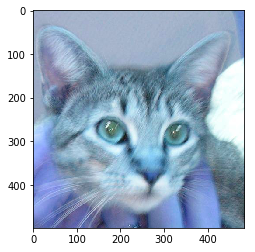

In [507]:
sample = df.sample()
print(sample['y'].values[0])
plt.imshow(cv2.imread(
    join(TRAIN_DIR, sample['filename'].values[0])
))
plt.show()


In [508]:
print("Cat cnt: {}, Dog cnt: {}".format(np.sum(df['y'] == 'Cat'), np.sum(df['y'] == 'Dog')) )

Cat cnt: 12500, Dog cnt: 12500


#### Model

In [514]:
class CatDogRecognitionModel(Model):
    def __init__(self):
        super(CatDogRecognitionModel, self).__init__()
        self.FilterSize1 = 32
        self.FilterSize2 = 64
        self.FilterSize3 = 128
        
        self.model_layers = [
            tf.keras.layers.Conv2D(filters=self.FilterSize1, kernel_size=(3, 3)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
            tf.keras.layers.Dropout(rate=0.3),

            tf.keras.layers.Conv2D(filters=self.FilterSize2, kernel_size=(3, 3)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
            tf.keras.layers.Dropout(rate=0.3),
            
            tf.keras.layers.Conv2D(filters=self.FilterSize3, kernel_size=(3, 3)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
            tf.keras.layers.Dropout(rate=0.3),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(rate=0.5),
            tf.keras.layers.Dense(2, activation='softmax'),
        ]
        
    def call(self, x, *args, **kwargs):
        for model_layer in self.model_layers:
            x = model_layer(x, *args, **kwargs)
        return x

model = CatDogRecognitionModel()

#### Train Input Generator

In [515]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True
)

train_generator = train_datagen.flow_from_dataframe(
        df_train.sample(n=int(len(df_train) * DF_RATE)),
        directory=TRAIN_DIR,
        x_col='filename', 
        y_col='y',
        target_size=(128, 128),
        batch_size=64,
        class_mode='binary')

Found 1750 validated image filenames belonging to 2 classes.


#### Test input generator

In [516]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_dataframe(
        df_test.sample(n=int(len(df_test) * DF_RATE)),
        directory=TRAIN_DIR,
        x_col='filename', 
        y_col='y',
        target_size=(128, 128),
        batch_size=64,
        class_mode='binary')

Found 750 validated image filenames belonging to 2 classes.


#### Input generator checking

Found 1 validated image filenames belonging to 1 classes.


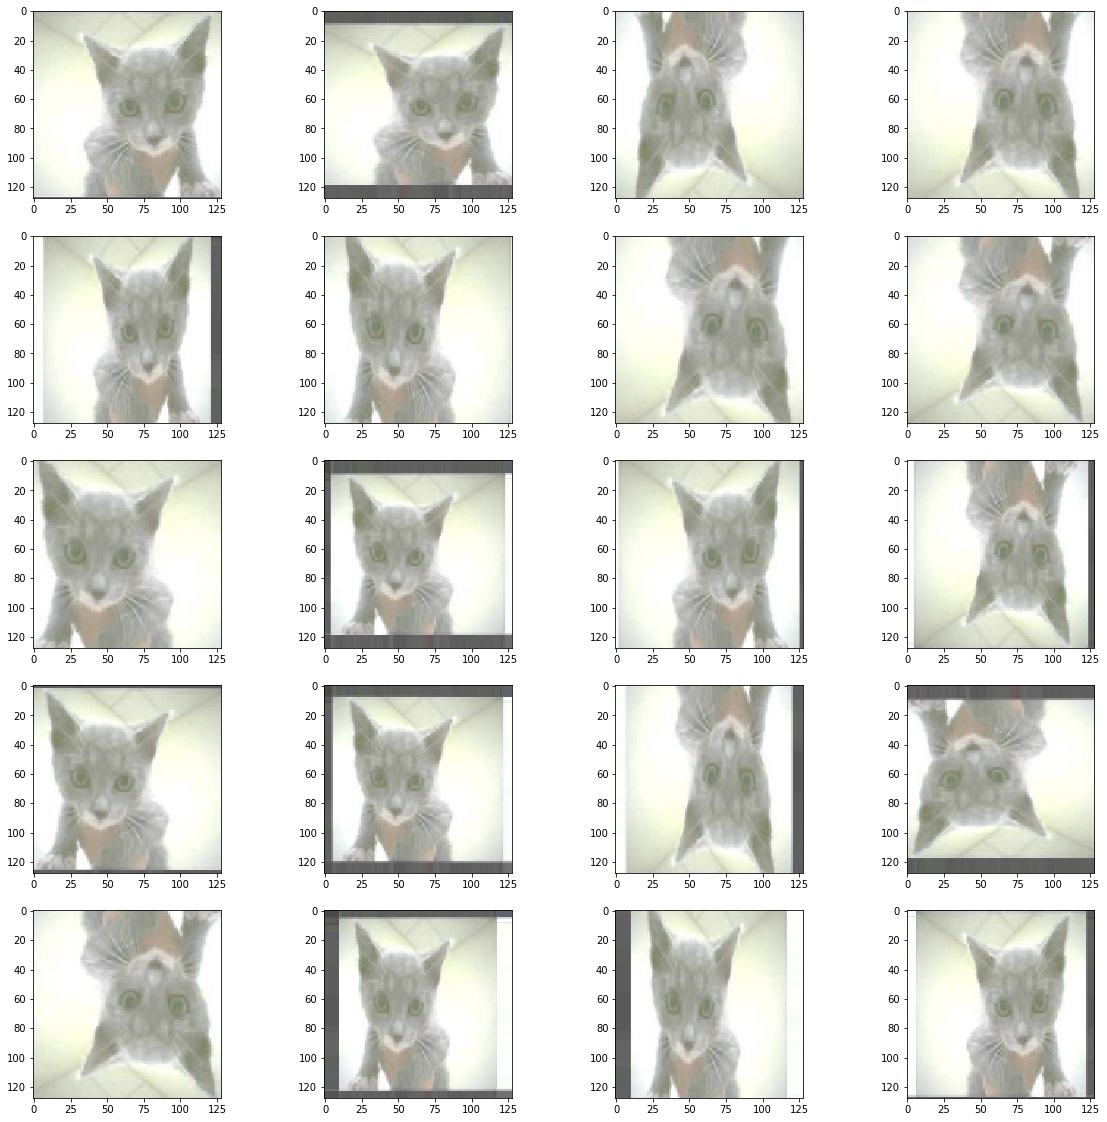

In [517]:
train_generator_example = train_datagen.flow_from_dataframe(
        df_train.iloc[0:1],
        directory=TRAIN_DIR,
        x_col='filename', 
        y_col='y',
        target_size=(128, 128),
        batch_size=64)

images = []
for i in range(20):
    img, labels = train_generator_example.next()
    #for j in range(img.shape[0]):
    images.append(img[0])
    

display_images(images, 4)

In [518]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

model.fit(
    x=train_generator,
    epochs=5,
    validation_data=test_generator
)

  ...
    to  
  ['...']
Train for 28 steps, validate for 12 steps
Epoch 1/5
28/28 [==============================] - 30s 1s/step - loss: 1.1789 - accuracy: 0.5509 - val_loss: 0.7870 - val_accuracy: 0.5173
Epoch 2/5
28/28 [==============================] - 30s 1s/step - loss: 0.8436 - accuracy: 0.5686 - val_loss: 0.8441 - val_accuracy: 0.5093
Epoch 3/5
28/28 [==============================] - 30s 1s/step - loss: 0.7928 - accuracy: 0.5743 - val_loss: 0.9594 - val_accuracy: 0.5320
Epoch 4/5
28/28 [==============================] - 29s 1s/step - loss: 0.7800 - accuracy: 0.5817 - val_loss: 11.7118 - val_accuracy: 0.5013
Epoch 5/5
28/28 [==============================] - 29s 1s/step - loss: 0.7809 - accuracy: 0.5800 - val_loss: 2.0724 - val_accuracy: 0.5120
